In [2]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# Helpful statement for debugging, prints the thing entered as x and the output, i.e.,
# debugPrint(1+1) will output '1+1 [int] = 2'
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
    
    
import os
import os, sys
# sys.path.append(os.path.join('~/dev/pytorchSPH/', "lib"))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm.notebook import trange, tqdm
import yaml
%matplotlib widget
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch
from torch_geometric.nn import radius
from torch_geometric.nn import SplineConv, fps, global_mean_pool, radius_graph, radius
from torch_scatter import scatter

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

import torch
# import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from tqdm import TqdmExperimentalWarning

warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)

In [3]:
import diffSPH

In [4]:
from diffSPH.deltaSPH import deltaSPHSimulation
from diffSPH.dfsph import dfsphSimulation

def loadConfig(config):
    with open(config, 'r') as file:
        tomlConfig = file.read()
    parsedConfig = tomli.loads(tomlConfig)
    simulationScheme = 'deltaSPH'
    if 'simulation' in parsedConfig:
        if 'scheme' in parsedConfig['simulation']:
            simulationScheme = parsedConfig['simulation']['scheme']
            
    if simulationScheme == 'deltaSPH' or simulationScheme == 'deltaPlus':
        return parsedConfig, deltaSPHSimulation
    if simulationScheme == 'dfsph':
        return parsedConfig, dfsphSimulation
    

Cuda compiler: /home/winchenbach/anaconda3/envs/torch2


In [5]:
import seaborn as sns
from diffSPH.util import evalArea
from diffSPH.noise.generator import generatePerlin, generateSimplex, generateOctaveNoise
from scipy import interpolate
from diffSPH.modules.neighborSearch import radiusCompactHashMap, periodicNeighborSearch
from diffSPH.util import scatter_sum
from diffSPH.kernels import *
from diffSPH.randomParticles import generatePeriodicRandomParticles

In [7]:

from diffSPH.modules.neighborSearch import periodicNeighborSearchXY
from diffSPH.kernels import getKernel


In [8]:
config = 'configs/periodicDomain.toml'

with open(config, 'r') as file:
    tomlConfig = file.read()
parsedConfig = tomli.loads(tomlConfig)

simulationModel = deltaSPHSimulation
# simulationModel = dfsphSimulation

sphSimulation = simulationModel(parsedConfig)
sphSimulation.initializeSimulation()
state = sphSimulation.simulationState
state['fluidVelocity'] = 4.0 * state['fluidVelocity'] / torch.max(torch.linalg.norm(state['fluidVelocity'], dim = -1))

# A = 1
# B = -1
# k = np.pi
# state['fluidVelocity'][:,0] =  4 * torch.cos(k * state['fluidPosition'][:,0]) * torch.sin(k * state['fluidPosition'][:,1])
# state['fluidVelocity'][:,1] = -4 * torch.sin(k * state['fluidPosition'][:,0]) * torch.cos(k * state['fluidPosition'][:,1])


sphSimulation.integrate()


/home/winchenbach/dev/diffSPH/src/diffSPH/simulationBase.py:350: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emitterPositions = torch.tensor(self.generated['ptcls'], dtype = self.dtype, device = self.device)


In [9]:
from diffSPH.modules.neighborSearch import periodicNeighborSearchXY
from diffSPH.kernels import kernel


nx = 128
x = np.linspace(-1,1,nx)
y = np.linspace(-1,1,nx)
# x = np.linspace(0,2*np.pi,nx)
# y = np.linspace(0,2*np.pi,nx)
xx, yy = np.meshgrid(x,y)
pos = torch.tensor(np.stack((xx,yy), axis = 2).reshape(nx * nx, 2), device = sphSimulation.simulationState['fluidPosition'].device, dtype = sphSimulation.simulationState['fluidPosition'].dtype)
print(pos.shape)
i, j, distances, radialDistances = periodicNeighborSearchXY(pos, sphSimulation.simulationState['fluidPosition'], 
                                                            sphSimulation.config['domain']['min'], sphSimulation.config['domain']['max'], 
                                                            sphSimulation.config['particle']['support'], 
                                                            sphSimulation.config['periodicBC']['periodicX'], sphSimulation.config['periodicBC']['periodicY'])


vel = scatter(sphSimulation.simulationState['fluidVelocity'][i] * (sphSimulation.simulationState['fluidArea'][i] / sphSimulation.simulationState['fluidDensity'][i] * kernel(radialDistances, sphSimulation.config['particle']['support']))[:,None], j, dim = 0, dim_size = nx**2, reduce = 'sum')


torch.Size([16384, 2])


/home/winchenbach/anaconda3/envs/torch2/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


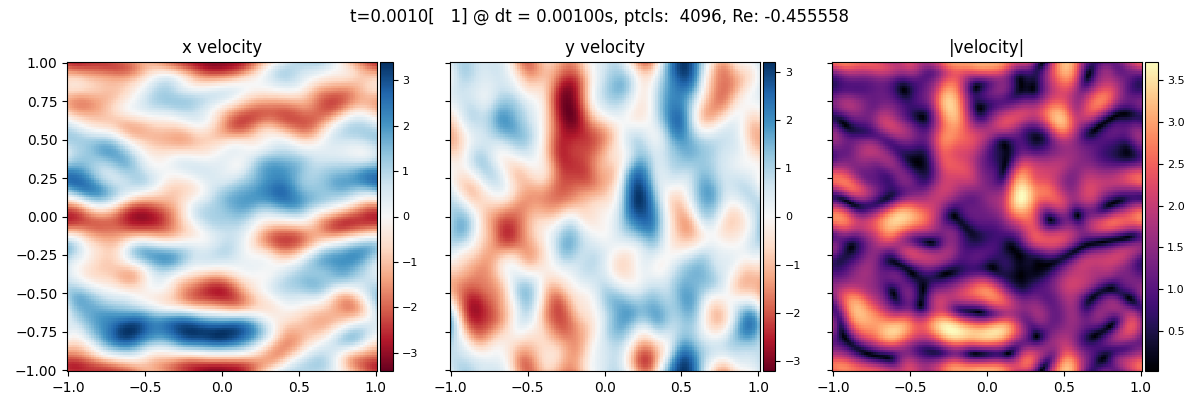

In [10]:

def updatePlot(sphSimulation, sc, pMeshX, pMeshY, pMeshN, pMeshV, fig, axis):
    nx = 128
    x = np.linspace(-1,1,nx)
    y = np.linspace(-1,1,nx)
    xx, yy = np.meshgrid(x,y)
    pos = torch.tensor(np.stack((xx,yy), axis = 2).reshape(nx * nx, 2), device = sphSimulation.simulationState['fluidPosition'].device, dtype = sphSimulation.simulationState['fluidPosition'].dtype)
#     print(pos.shape)
    i, j, distances, radialDistances = periodicNeighborSearchXY(pos, sphSimulation.simulationState['fluidPosition'], 
                                                                sphSimulation.config['domain']['min'], sphSimulation.config['domain']['max'], 
                                                                sphSimulation.config['particle']['support'], 
                                                                sphSimulation.config['periodicBC']['periodicX'], sphSimulation.config['periodicBC']['periodicY'])

    vel = scatter(sphSimulation.simulationState['fluidVelocity'][i] * (sphSimulation.simulationState['fluidArea'][i] / sphSimulation.simulationState['fluidDensity'][i] * kernel(radialDistances, sphSimulation.config['particle']['support']))[:,None], j, dim = 0, dim_size = nx**2, reduce = 'sum')
    xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
    yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()

    vorticity = np.gradient(yVel)[0] - np.gradient(xVel)[1]

    # pMeshV.set_array(vorticity)
    pMeshX.set_array(xVel)
    pMeshY.set_array(yVel)
    pMeshN.set_array(np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2))

        
    positions = state['fluidPosition'].detach().cpu().numpy()
    data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
    minD = torch.tensor(sphSimulation.config['domain']['min']).cpu().numpy()
    maxD = torch.tensor(sphSimulation.config['domain']['max']).cpu().numpy()
    # y = np.remainder(positions - minD, maxD - minD) + minD
    # sc.set_offsets(np.c_[y[:,0], y[:,1]])
    # sc.set_array(data)

    nu = np.log(data.max()/4) /(-2 * np.pi**2 * sphSimulation.simulationState['time']) / 4
    Re = data.max() * 2 / nu
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d, Re: %g'%(sphSimulation.simulationState['time'], sphSimulation.simulationState['timestep'], sphSimulation.simulationState['dt'],sphSimulation.simulationState['numParticles'], Re))
    # axis[0,0].cla()
    # axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
    # axis[0,0].set_xlim(-1,1)
    # axis[0,0].set_ylim(-1,1)
    # axis[0,0].set_aspect(1)
    
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = True, sharey = True, squeeze = False)


def pMesh(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'magma')
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

def pMesh2(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'RdBu', vmin = -np.max(np.abs(data)), vmax = np.max(np.abs(data)))
    # sc = axis.pcolormesh(xx,yy,data, cmap = 'icefire', vmin = -2.5, vmax = 2.5)
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()
vorticity = np.gradient(yVel)[0] - np.gradient(xVel)[1]
state = sphSimulation.simulationState
# pMeshV = pMesh2(fig,axis[0,0], xx, yy, vorticity, 'vorticity')
positions = state['fluidPosition'].detach().cpu().numpy()
data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
minD = torch.tensor(sphSimulation.config['domain']['min']).cpu().numpy()
maxD = torch.tensor(sphSimulation.config['domain']['max']).cpu().numpy()
y = np.remainder(positions - minD, maxD - minD) + minD
# sc = axis[0,0].scatter(y[:,0], y[:,1], c = torch.linalg.norm(sphSimulation.simulationState['fluidVelocity'], dim = -1).cpu().numpy(), s = 1,cmap = 'magma')
# axis[0,0].set_xlim(-1,1)
# axis[0,0].set_ylim(-1,1)
# axis[0,0].set_aspect(1)
# axis[0,0].axis('equal')
# axis[0,0].set_box_aspect(1)
# axis[0,0].set_title('Particle |velocity|')

pMeshX = pMesh2(fig,axis[0,0], xx, yy, xVel, 'x velocity')
pMeshY = pMesh2(fig,axis[0,1], xx, yy, yVel, 'y velocity')
pMeshN = pMesh( fig,axis[0,2], xx, yy, np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), '|velocity|')
    
# axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
# axis[0,0].set_xlim(-1,1)
# axis[0,0].set_ylim(-1,1)
# axis[0,0].set_aspect(1)
# axis[0,0].axis('equal')
nu = np.log(data.max()) /(-2 * np.pi**2 * sphSimulation.simulationState['time']) / 4
Re = data.max() * 2 / nu
fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d, Re: %g'%(sphSimulation.simulationState['time'], sphSimulation.simulationState['timestep'], sphSimulation.simulationState['dt'],sphSimulation.simulationState['numParticles'], Re))
        
fig.tight_layout()

# timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# path = '../../images/periodic/%s - %s/' % (config.split('/')[-1].split('.')[0], timestamp)
# if not os.path.exists(path):
#     os.makedirs(path)
# timesteps = 4096 * 4
# # timesteps = 2424
# for i in tqdm(range(timesteps)):
#     sphSimulation.integrate()
# #     break
# #     sphSimulation.timestep()
#     if i  % 64 == 0 or i == timesteps - 1:
# #     if True:
#         state = sphSimulation.simulationState        

#         updatePlot(sphSimulation, sc, pMeshX, pMeshY, pMeshN, pMeshV, fig, axis)
        
#         fig.canvas.draw()
#         fig.canvas.flush_events()
        
#         imagePath = path + '%05d.png' % state['timestep']
#         # plt.savefig(imagePath)

In [11]:
# timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# path = '../../images/periodic/%s - %s/' % (config.split('/')[-1].split('.')[0], timestamp)
# if not os.path.exists(path):
#     os.makedirs(path)
timesteps = 512
# timesteps = 2424
for i in tqdm(range(timesteps)):
    sphSimulation.integrate()
#     break
#     sphSimulation.timestep()
    if i  % 64 == 0 or i == timesteps - 1:
#     if True:
        state = sphSimulation.simulationState        

        updatePlot(sphSimulation, None, pMeshX, pMeshY, pMeshN, None, fig, axis)
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        
        # imagePath = path + '%05d.png' % state['timestep']
        # plt.savefig(imagePath)

  0%|          | 0/512 [00:00<?, ?it/s]

In [16]:

@torch.jit.script
def mod(x, min : float, max : float):
    return torch.where(torch.abs(x) > (max - min) / 2, torch.sgn(x) * ((torch.abs(x) + min) % (max - min) + min), x)
    
@torch.jit.script
def radiusNaive(x, y, hx, hy, periodicX : bool = False, periodicY : bool = False, minDomain = None, maxDomain = None, mode : str = 'gather'):
    if periodicX and not periodicY:
        pos_x = torch.stack((torch.remainder(x[:,0] - minDomain[0], maxDomain[0] - minDomain[0]) + minDomain[0], x[:,1]), dim = 1)
        pos_y = torch.stack((torch.remainder(y[:,0] - minDomain[0], maxDomain[0] - minDomain[0]) + minDomain[0], y[:,1]), dim = 1)
    elif not periodicX and periodicY:
        pos_x = torch.stack((x[:,0], torch.remainder(x[:,1] - minDomain[1], maxDomain[1] - minDomain[1]) + minDomain[1]), dim = 1)
        pos_y = torch.stack((y[:,0], torch.remainder(y[:,1] - minDomain[1], maxDomain[1] - minDomain[1]) + minDomain[1]), dim = 1)
    elif periodicX and periodicY:
        pos_x = torch.remainder(x - minDomain, maxDomain - minDomain) + minDomain
        pos_y = torch.remainder(y - minDomain, maxDomain - minDomain) + minDomain
    else:
        pos_x = x
        pos_y = y
    
    distanceMatrix_x = pos_x[:,0] - pos_y[:,0,None]
    distanceMatrix_y = pos_x[:,1] - pos_y[:,1,None]
    if periodicX:
        distanceMatrix_x = mod(distanceMatrix_x, minDomain[0], maxDomain[0])
    if periodicY:
        distanceMatrix_y = mod(distanceMatrix_y, minDomain[1], maxDomain[1])
    
    distanceMatrix = torch.sqrt(distanceMatrix_x**2 + distanceMatrix_y**2)
    
    indexI, indexJ = torch.meshgrid(torch.arange(x.shape[0]).to(x.device), torch.arange(y.shape[0]).to(y.device), indexing = 'xy')
    if mode == 'gather':        
        gatherMatrix = hx.repeat(hy.shape[0],1)
        adjacencyDense = distanceMatrix <= gatherMatrix
        supports = gatherMatrix[adjacencyDense]
    elif mode == 'scatter':        
        scatterMatrix = hy.repeat(hx.shape[0],1).mT
        adjacencyDense = distanceMatrix <= scatterMatrix
        supports = scatterMatrix[adjacencyDense]
    else:
        symmetricMatrix = (hx + hy[:,None]) / 2
        adjacencyDense = distanceMatrix <= symmetricMatrix
        supports = symmetricMatrix[adjacencyDense]
    
    ii = indexI[adjacencyDense]
    jj = indexJ[adjacencyDense]

    return ii, jj, distanceMatrix[adjacencyDense], torch.stack((distanceMatrix_x[adjacencyDense], distanceMatrix_y[adjacencyDense]), dim = 1), supports

In [17]:
def neighborSearch(x, y, hx, hy, periodicX : bool = False, periodicY : bool = False, minDomain = None, maxDomain = None, mode : str = 'gather'):
    if minDomain is not None and isinstance(minDomain, list):
        minD = torch.tensor(minDomain).to(x.device).type(x.dtype)
    else:
        minD = minDomain
    if maxDomain is not None and isinstance(minDomain, list):
        maxD = torch.tensor(maxDomain).to(x.device).type(x.dtype)
    else:
        maxD = maxDomain
    
    
    i, j, rij, xij, hij = radiusNaive(x, y, 
                            hx if isinstance(hx, torch.Tensor) else torch.ones(x.shape[0]).to(x.device).to(x.dtype) * hx, hy if isinstance(hy, torch.Tensor) else torch.ones(y.shape[0]).to(y.device).to(y.dtype) * hy, 
                            periodicX = periodicX, periodicY = periodicY, minDomain = minD, maxDomain = maxD)
    
    xij_normed = torch.nn.functional.normalize(xij)
    rij_normed = rij / hij

    return i, j, rij_normed, xij_normed, hij

In [18]:
# @torch.jit.script
# def wendland4(q, h):
#     C = 7 / np.pi
#     b1 = torch.pow(1. - q, 4)
#     b2 = 1.0 + 4.0 * q
#     return b1 * b2 * C / h**2  
# @torch.jit.script
# def wendland4Grad(q,r,h):
#     C = 7 / np.pi    
#     return - r * C * (20. * q * (1. -q)**3/ h**3 )[:,None]

In [19]:
Kernel = getKernel('Wendland2')

positions = sphSimulation.simulationState['fluidPosition']

x = torch.clone(positions)
y = torch.clone(positions[:positions.shape[0]//2,:])
y = torch.clone(positions)
# print(y)
hx = torch.clone(sphSimulation.perennialState['fluidSupport'])
hy = torch.clone(sphSimulation.perennialState['fluidSupport'][:y.shape[0]])


periodicX = True
periodicY = True
minDomain = [-1,-1]
maxDomain = [1,1]

i, j, rij, xij, hij = neighborSearch(x, y, hx, hy, periodicX, periodicY, minDomain, maxDomain)

kernel = Kernel.kernel(rij, hij)
gradKernel = Kernel.kernelGradient(rij, xij, hij)

In [98]:
@torch.jit.script 
def sphOperation_interpolation_scalar(mass_j, density_j, quantity_j, neighborhood, kernels, numParticles : int):
    i = neighborhood[0]
    j = neighborhood[1]
    k = mass_j[j] / density_j[j] * kernels
    kq = k * quantity_j[j]
    
    return scatter(kq, i, dim = 0, dim_size = numParticles, reduce = 'add')
@torch.jit.script 
def sphOperation_interpolation_vec(mass_j, density_j, quantity_j, neighborhood, kernels, numParticles : int):
    i = neighborhood[0]
    j = neighborhood[1]
    k = mass_j[j] / density_j[j] * kernels
    kq = k.view(-1,1) * quantity_j[j]
    
    return scatter(kq, i, dim = 0, dim_size = numParticles, reduce = 'add')
@torch.jit.script 
def sphOperation_interpolation_mat(mass_j, density_j, quantity_j, neighborhood, kernels, numParticles : int):
    i = neighborhood[0]
    j = neighborhood[1]
    k = mass_j[j] / density_j[j] * kernels
    kq = k.view(-1,1,1) * quantity_j[j]
    
    return scatter(kq, i, dim = 0, dim_size = numParticles, reduce = 'add')
    
# @torch.jit.script 
def sphOperation_interpolation_generic(mass_j, density_j, quantity_j, neighborhood, kernels, numParticles : int):
    i = neighborhood[0]
    j = neighborhood[1]
    k = mass_j[j] / density_j[j] * kernels
    kq = k.view(-1,*([1] * (len(quantity_j.shape) - 1) )) * quantity_j[j]
    
    return scatter(kq, i, dim = 0, dim_size = numParticles, reduce = 'add')

@torch.jit.script
def sphOperation_interpolation(mass_j, density_j, quantity_j, neighborhood, kernels, numParticles : int):
    if quantity_j.dim() == 1:
        return sphOperation_interpolation_scalar(mass_j, density_j, quantity_j, neighborhood, kernels, numParticles)
    elif quantity_j.dim() == 2:
        return sphOperation_interpolation_vec(mass_j, density_j, quantity_j, neighborhood, kernels, numParticles)
    else:
        return sphOperation_interpolation_mat(mass_j, density_j, quantity_j, neighborhood, kernels, numParticles)


In [99]:

def sphOperation(masses, densities, quantities, neighborhood, kernels, kernelGradients, radialDistances, directions, numParticles : int, operation : str = 'interpolate'):
    if operation == 'interpolate':
        return sphOperation_interpolation(masses[1], densities[1], quantities[1], neighborhood, kernels, numParticles)

    

In [95]:
scalar = torch.ones(16)
matrix = torch.ones(16,2,2)

scalar.expand(matrix.shape) * matrix

RuntimeError: The expanded size of the tensor (2) must match the existing size (16) at non-singleton dimension 2.  Target sizes: [16, 2, 2].  Tensor sizes: [16]

In [85]:
[1] * 0

[]

In [66]:
sliced = ([None]*0)
slice(*sliced)

TypeError: slice expected at least 1 argument, got 0

In [20]:
def sampleRegular(nx = 32, minExtent = [-1, -1], maxExtent = [1,1], targetNeighbors = 50, correctedArea = False):
    dx = (maxExtent[0] - minExtent[0]) / nx            
    area = dx**2
    if correctedArea:
        area =  minimize(lambda r: evalArea(r[0], dx, torch.float32, 'cpu', targetNeighbors = targetNeighbors), area, method="nelder-mead", bounds =[(area * 1e-5,area *2)], tol = 1e-7).x[0]
    support = np.single(np.sqrt(area / np.pi * targetNeighbors))
    
    
    xx = np.linspace(minDomain[0] + dx / 2, maxExtent[0] - dx / 2, nx)
    yy = np.linspace(minDomain[1] + dx / 2, maxExtent[1] - dx / 2, nx)

    XX, YY = np.meshgrid(xx,yy)
    ptcls = np.stack((XX,YY), axis = 2).flatten().reshape((nx * nx, 2))

    return torch.tensor(ptcls), torch.ones(ptcls.shape[0]) * area, torch.ones(ptcls.shape[0]) * support

def sphInterpolation(fluidMasses, fluidDensities, fluidQuantities, fluidNeighbors, fluidKernels, fluidKernelGradients, numParticles):
    i = fluidNeighbors[0]
    j = fluidNeighbors[1]
    return scatter(fluidMasses[1][j] / fluidDensities[1][j] * fluidQuantities[1][j] * fluidKernels, i, dim = 0, dim_size = numParticles, reduce = 'add')


In [21]:
import matplotlib

In [47]:
def visualizeParticles(fig, axis, x, area, h, inputQuantity, periodicX = False, periodicY = False, minDomain = None, maxDomain = None, mapping = '.x', cbar = True, cmap = 'viridis', scaling = 'symlog', s = 4, linthresh = 0.5, midPoint = 1, interpolant = None):        
    print(inputQuantity.shape)

    if len(inputQuantity.shape) == 2:
        # Non scalar quantity
        if mapping == '.x' or mapping == '[0]':
            quantity = inputQuantity[:,0]
        if mapping == '.y' or mapping == '[1]':
            quantity = inputQuantity[:,1]
        if mapping == '.z' or mapping == '[2]':
            quantity = inputQuantity[:,2]
        if mapping == '.w' or mapping == '[3]':
            quantity = inputQuantity[:,3]
        if mapping == 'Linf':
            quantity = torch.linalg.norm(inputQuantity, dim = -1, ord = float('inf'))
        if mapping == 'L-inf':
            quantity = torch.linalg.norm(inputQuantity, dim = -1, ord = -float('inf'))
        if mapping == 'L0':
            quantity = torch.linalg.norm(inputQuantity, dim = -1, ord = 0)
        if mapping == 'L1':
            quantity = torch.linalg.norm(inputQuantity, dim = -1, ord = 1)
        if mapping == 'L2' or mapping == 'norm' or mapping == 'magnitude':
            quantity = torch.linalg.norm(inputQuantity, dim = -1, ord = 2)
        if mapping == 'theta':
            quantity = torch.atan2(inputQuantity[:,1], inputQuantity[:,0])

        
    
    else:
        quantity = inputQuantity

    if interpolant is not None:
        i, j, rij, xij, hij = neighborSearch(x, x, h, h, periodicX, periodicY, minDomain, maxDomain)
        Kernel = getKernel('Wendland2')
        
        kernel = Kernel.kernel(rij, hij)
        gradKernel = Kernel.kernelGradient(rij, xij, hij)
        density = sphInterpolation((None,area), (None, torch.ones_like(area)), (None, torch.ones_like(area)), (i, j), kernel, gradKernel, x.shape[0])

        print(density)
        if interpolant == 'SPH':
            quantity = sphInterpolation((None,area), (None, density), (None, quantity), (i, j), kernel, gradKernel, x.shape[0])
    
    minD = torch.tensor(minDomain).to(x.device).type(x.dtype)
    maxD = torch.tensor(maxDomain).to(x.device).type(x.dtype)
    
    if periodicX and not periodicY:
        pos_x = torch.stack((torch.remainder(x[:,0] - minD[0], maxD[0] - minD[0]) + minD[0], x[:,1]), dim = 1)
    elif not periodicX and periodicY:
        pos_x = torch.stack((x[:,0], torch.remainder(x[:,1] - minD[1], maxD[1] - minD[1]) + minD[1]), dim = 1)
    elif periodicX and periodicY:
        pos_x = torch.remainder(x - minD, maxD - minD) + minD
    else:
        pos_x = x  

    minScale = torch.min(quantity)
    maxScale = torch.max(quantity)
    if 'sym' in scaling:
        minScale = - torch.max(torch.abs(quantity))
        maxScale =   torch.max(torch.abs(quantity))
        if 'log'in scaling:
            norm = matplotlib.colors.SymLogNorm(vmin = minScale, vmax = maxScale, linthresh = linthresh)
        else:
            minScale = - torch.max(torch.abs(quantity - midPoint))
            maxScale =   torch.max(torch.abs(quantity - midPoint))
            norm = matplotlib.colors.CenteredNorm(vcenter = midPoint, halfrange = maxScale)
    else:
        if 'log'in scaling:
            vmm = torch.min(torch.abs(quantity[quantity!= 0]))
            norm = matplotlib.colors.LogNorm(vmin = vmm, vmax = maxScale)
        else:
            norm = matplotlib.colors.Normalize(vmin = minScale, vmax = maxScale)
        
    sc = axis.scatter(pos_x[:,0].detach().cpu().numpy(), pos_x[:,1].detach().cpu().numpy(), s = s, c = quantity.detach().cpu().numpy(), cmap = cmap, norm = norm)
    if cbar:
        ax1_divider = make_axes_locatable(axis)
        cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
        cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
        cb.ax.tick_params(labelsize=8)
    if periodicX:
        axis.axis('equal')
        axis.set_xlim(minDomain[0], maxDomain[0])
        axis.set_ylim(minDomain[1], maxDomain[1])
    else:
        axis.set_aspect('equal', 'box')

    return {'plot': sc, 'cbar': cb if cbar else None, 'periodic': (periodicX, periodicY), 'domain': (minDomain, maxDomain), 'mapping': mapping, 'colormap': cmap, 'scale': scaling, 'size':4}
    

torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
tensor([1.0010, 1.0005, 0.9987,  ..., 0.9979, 1.0003, 1.0000], device='cuda:0')


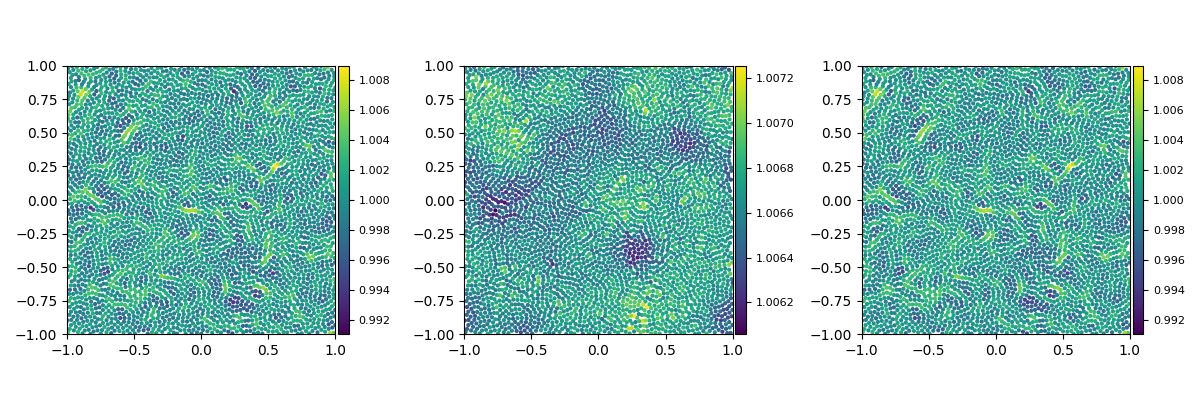

In [53]:


x = torch.clone(positions)
hx = torch.clone(sphSimulation.perennialState['fluidSupport'])
h = torch.max(hx).item()
area = sphSimulation.simulationState['fluidArea']


i, j, rij, xij, hij = neighborSearch(x, x, h, h, True, True, minDomain, maxDomain)
Kernel = getKernel('Wendland2')

kernel = Kernel.kernel(rij, hij)
gradKernel = Kernel.kernelGradient(rij, xij, hij)


density = sphInterpolation((None,sphSimulation.simulationState['fluidArea']), (None, torch.ones_like(sphSimulation.simulationState['fluidArea'])), (None, torch.ones_like(sphSimulation.simulationState['fluidArea'])), (i, j), kernel, gradKernel, x.shape[0])
# density = sphInterpolation((None,area), (None, torch.ones_like(area)), (None, torch.ones_like(area)), (i, j), kernel, gradKernel, x.shape[0])



fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)


visualizeParticles(fig, axis[0,0], 
                   x, area, h, density, 
                   periodicX, periodicY, minDomain, maxDomain, 
                   mapping = '.x', cbar = True, cmap = 'viridis', scaling = 'sym', s = 4, midPoint = 1)
visualizeParticles(fig, axis[0,1], 
                   x, area, h, sphSimulation.simulationState['fluidDensity'], 
                   periodicX, periodicY, minDomain, maxDomain, 
                   mapping = '.y', cbar = True, cmap = 'viridis', scaling = 'lin', s = 4, midPoint = 1)
visualizeParticles(fig, axis[0,2], 
                   x, area, h, density, 
                   periodicX, periodicY, minDomain, maxDomain, 
                   mapping = '.x', cbar = True, cmap = 'viridis', scaling = 'sym', s = 4, midPoint = 1, interpolant = 'SPH')

fig.tight_layout()

In [ ]:
x, area, h = sampleRegular(64, targetNeighbors = 50, correctedArea = True)



# x = torch.clone(positions)
# hx = torch.clone(sphSimulation.perennialState['fluidSupport'])
# h = torch.max(hx).item()

i, j, rij, xij, hij = neighborSearch(x, x, h, h, True, True, minDomain, maxDomain)
Kernel = getKernel('Wendland2')

kernel = Kernel.kernel(rij, hij)
gradKernel = Kernel.kernelGradient(rij, xij, hij)


# density = sphInterpolation((None,sphSimulation.simulationState['fluidArea']), (None, torch.ones_like(sphSimulation.simulationState['fluidArea'])), (None, torch.ones_like(sphSimulation.simulationState['fluidArea'])), (i, j), kernel, gradKernel, x.shape[0])
density = sphInterpolation((None,area), (None, torch.ones_like(area)), (None, torch.ones_like(area)), (i, j), kernel, gradKernel, x.shape[0])


fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

sc = axis[0,0].scatter(x[:,0].detach().cpu().numpy(), x[:,1].detach().cpu().numpy(), s = 4, c = torch.arange(x.shape[0]), cmap = 'twilight')
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8)
axis[0,0].axis('equal')

ii, ni = torch.unique(i, return_counts = True)
padded_ni = torch.zeros(x.shape[0]).to(x.device).type(ii.dtype)
padded_ni[ii] = ni

sc = axis[0,1].scatter(x[:,0].detach().cpu().numpy(), x[:,1].detach().cpu().numpy(), s = 4, c = padded_ni.cpu().numpy(), cmap = 'plasma')
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8)
axis[0,1].axis('equal')


sc = axis[0,2].scatter(x[:,0].detach().cpu().numpy(), x[:,1].detach().cpu().numpy(), s = 4, c = density.cpu().numpy())
ax1_divider = make_axes_locatable(axis[0,2])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8)
axis[0,2].axis('equal')

fig.tight_layout()

print('Area: min %g, max %g, mean %g, stddev %g' %(area.min().item(), area.max().item(), area.mean().item(), area.std().item()))
print('rij: min %g, max %g, mean %g, stddev %g' %(rij.min().item(), rij.max().item(), rij.mean().item(), rij.std().item()))
print('kernel: min %g, max %g, mean %g, stddev %g' %(kernel.min().item(), kernel.max().item(), kernel.mean().item(), kernel.std().item()))
print('Density: min %g, max %g, mean %g, stddev %g' %(density.min().item(), density.max().item(), density.mean().item(), density.std().item()))
print(x.shape)

In [ ]:


density = sphInterpolation((None,sphSimulation.simulationState['fluidArea']), (None, torch.ones_like(sphSimulation.simulationState['fluidArea'])), (None, torch.ones_like(sphSimulation.simulationState['fluidArea'])), (i, j), kernel, gradKernel, x.shape[0])

fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex = False, sharey = False, squeeze = False)

sc = axis[0,0].scatter(x[:,0].detach().cpu().numpy(), x[:,1].detach().cpu().numpy(), s = 1, c = density.cpu().numpy())
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8)

In [ ]:
density

/home/winchenbach/anaconda3/envs/torch2/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


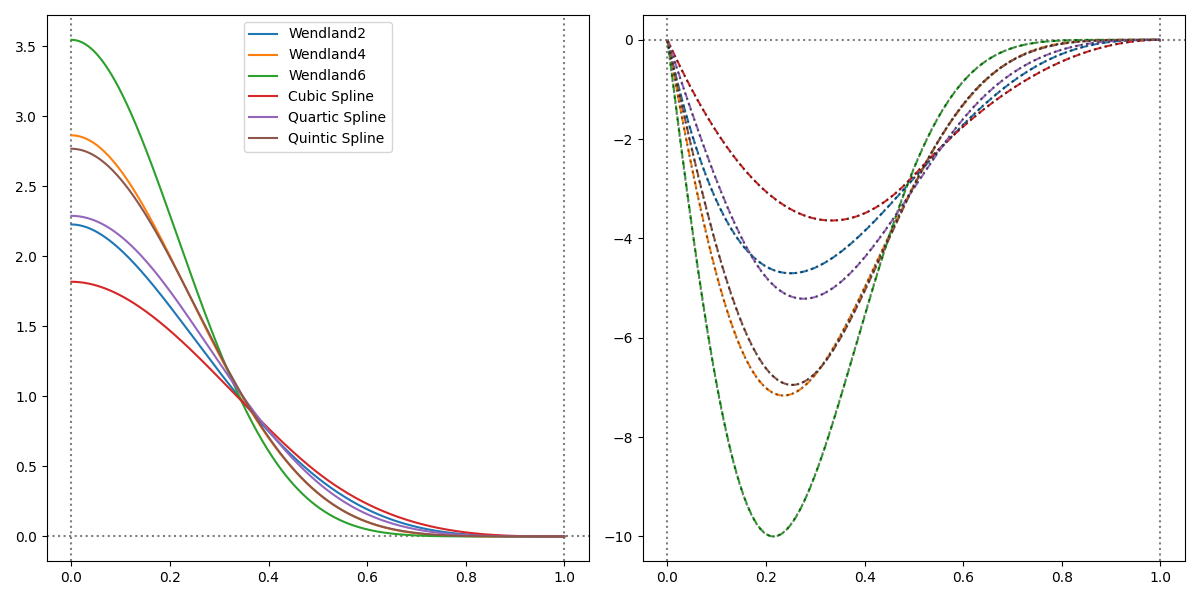

In [ ]:
print(radialDistances.max())
print(hx.max())

In [ ]:
x = torch.clone(positions)
y = torch.clone(positions[:positions.shape[0]//2,:])
# y = torch.clone(positions)
# print(y)
hx = torch.clone(sphSimulation.perennialState['fluidSupport'])
hy = torch.clone(sphSimulation.perennialState['fluidSupport'][:y.shape[0]])


periodicX = True
periodicY = True
minDomain = [-1,-1]
maxDomain = [1,1]

minD = torch.tensor(minDomain).to(x.device).type(x.dtype)
maxD = torch.tensor(maxDomain).to(x.device).type(x.dtype)

i, j, rij, xij, hij = radiusNaive(x, y, hx, hy, periodicX = periodicX, periodicY = periodicY, minDomain = minD, maxDomain = maxD)

neighbors = torch.vstack((i,j))

ii, ni = torch.unique(i, return_counts = True)
padded_ni = torch.zeros_like(hx).type(ii.dtype)
padded_ni[ii] = ni

jj, nj = torch.unique(j, return_counts = True)
padded_nj = torch.zeros_like(hy).type(jj.dtype)
padded_nj[jj] = nj

# display(distanceMatrix < h)
fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex = False, sharey = False, squeeze = False)

sc = axis[0,0].scatter(x[:,0].detach().cpu().numpy(), x[:,1].detach().cpu().numpy(), s = 1, c = padded_ni.cpu().numpy())
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8)

sc = axis[0,1].scatter(y[:,0].detach().cpu().numpy(), y[:,1].detach().cpu().numpy(), s = 1, c = padded_nj.cpu().numpy())
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8)

fig.tight_layout()

In [ ]:
ii.max()
jj.max()

In [ ]:
((hx + hy[:,None]) / 2).shape

In [ ]:
hy.repeat(hx.shape[0],1).mT.shape

In [ ]:
config = 'configs/periodicDomain.toml'

with open(config, 'r') as file:
    tomlConfig = file.read()
parsedConfig = tomli.loads(tomlConfig)

simulationModel = deltaSPHSimulation
# simulationModel = dfsphSimulation

sphSimulation = simulationModel(parsedConfig)
sphSimulation.initializeSimulation()
state = sphSimulation.simulationState
state['fluidVelocity'] = 4.0 * state['fluidVelocity'] / torch.max(torch.linalg.norm(state['fluidVelocity'], dim = -1))

# A = 1
# B = -1
# k = np.pi
# state['fluidVelocity'][:,0] =  4 * torch.cos(k * state['fluidPosition'][:,0]) * torch.sin(k * state['fluidPosition'][:,1])
# state['fluidVelocity'][:,1] = -4 * torch.sin(k * state['fluidPosition'][:,0]) * torch.cos(k * state['fluidPosition'][:,1])


sphSimulation.integrate()

from BasisConvolution.twoDimensionalSPH.modules.neighborSearch import periodicNeighborSearchXY
from BasisConvolution.twoDimensionalSPH.kernels import kernel

nx = 128
x = np.linspace(-1,1,nx)
y = np.linspace(-1,1,nx)
# x = np.linspace(0,2*np.pi,nx)
# y = np.linspace(0,2*np.pi,nx)
xx, yy = np.meshgrid(x,y)
pos = torch.tensor(np.stack((xx,yy), axis = 2).reshape(nx * nx, 2), device = sphSimulation.simulationState['fluidPosition'].device, dtype = sphSimulation.simulationState['fluidPosition'].dtype)
print(pos.shape)
i, j, distances, radialDistances = periodicNeighborSearchXY(pos, sphSimulation.simulationState['fluidPosition'], 
                                                            sphSimulation.config['domain']['min'], sphSimulation.config['domain']['max'], 
                                                            sphSimulation.config['particle']['support'], 
                                                            sphSimulation.config['periodicBC']['periodicX'], sphSimulation.config['periodicBC']['periodicY'])


vel = scatter(sphSimulation.simulationState['fluidVelocity'][i] * (sphSimulation.simulationState['fluidArea'][i] / sphSimulation.simulationState['fluidDensity'][i] * kernel(radialDistances, sphSimulation.config['particle']['support']))[:,None], j, dim = 0, dim_size = nx**2, reduce = 'sum')

fig, axis = plt.subplots(1, 6, figsize=(20,4), sharex = False, sharey = False, squeeze = False)
xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()

axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)

axis[0,0].set_xlim(-1,1)
axis[0,0].set_ylim(-1,1)
# axis[0,0].set_xlim(0,2*np.pi)
# axis[0,0].set_ylim(0,2*np.pi)
axis[0,0].set_aspect(1)
axis[0,0].axis('equal')
# fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)


def pMesh(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'magma')
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

def pMesh2(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'RdBu', vmin = -np.max(np.abs(data)), vmax = np.max(np.abs(data)))
    # sc = axis.pcolormesh(xx,yy,data, cmap = 'icefire', vmin = -2.5, vmax = 2.5)
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc
def pMesh3(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'jet', vmin = -np.max(np.abs(data)), vmax = np.max(np.abs(data)))
    # sc = axis.pcolormesh(xx,yy,data, cmap = 'icefire', vmin = -2.5, vmax = 2.5)
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()
vorticity = np.gradient(yVel)[0] - np.gradient(xVel)[1]
divergence = np.gradient(xVel)[0] - np.gradient(xVel)[1]

pMeshV = pMesh3(fig,axis[0,1], xx, yy, divergence, 'divergence')
pMeshV = pMesh2(fig,axis[0,2], xx, yy, vorticity, 'vorticity')
pMeshX = pMesh2(fig,axis[0,3], xx, yy, xVel, 'x velocity')
pMeshY = pMesh2(fig,axis[0,4], xx, yy, yVel, 'y velocity')
pMeshN = pMesh( fig,axis[0,5], xx, yy, np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), '|velocity|')
    
# axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
# axis[0,0].set_xlim(-1,1)
# axis[0,0].set_ylim(-1,1)
# axis[0,0].set_aspect(1)
# axis[0,0].axis('equal')
fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d'%(sphSimulation.simulationState['time'], sphSimulation.simulationState['timestep'], sphSimulation.simulationState['dt'],sphSimulation.simulationState['numParticles']))

fig.tight_layout()

In [ ]:
fig, axis = plt.subplots(1, 1, figsize=(6,6), sharex = False, sharey = False, squeeze = False)
state = sphSimulation.simulationState
axis[0,0].set_xticks([])
axis[0,0].set_yticks([])

positions = state['fluidPosition'].detach().cpu().numpy()
data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
data = state['fluidPressure'].detach().cpu().numpy()
# data = ni.detach().cpu().numpy()

minD = torch.tensor(sphSimulation.config['domain']['min']).cpu().numpy()
maxD = torch.tensor(sphSimulation.config['domain']['max']).cpu().numpy()
y = np.remainder(positions - minD, maxD - minD) + minD

sc = axis[0,0].scatter(y[:,0], y[:,1], c = data, s = 2)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

fig.suptitle('Generated [%2d:%2d]+[%2d:%2d] res, %2dx%2d noise, %3.2g @ seed %5d' % (sphSimulation.config['generative']['nb'][0],sphSimulation.config['generative']['nb'][1],sphSimulation.config['generative']['nd'][0],sphSimulation.config['generative']['nd'][1], sphSimulation.config['generative']['res'], sphSimulation.config['generative']['octaves'], sphSimulation.config['generative']['persistance'], sphSimulation.config['generative']['seed']))
axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d'%(state['time'], state['timestep'], state['dt'],state['numParticles']))

axis[0,0].set_xlim(-1.1,1.1)
axis[0,0].set_ylim(-1.1,1.1)
axis[0,0].axvline(-1)
axis[0,0].axvline(1)
axis[0,0].axhline(-1)
axis[0,0].axhline(1)


fig.tight_layout()



In [ ]:

nx = 128
x = np.linspace(-1,1,nx)
y = np.linspace(-1,1,nx)
xx, yy = np.meshgrid(x,y)
pos = torch.tensor(np.stack((xx,yy), axis = 2).reshape(nx * nx, 2), device = sphSimulation.simulationState['fluidPosition'].device, dtype = sphSimulation.simulationState['fluidPosition'].dtype)
#     print(pos.shape)
i, j, distances, radialDistances = periodicNeighborSearchXY(pos, sphSimulation.simulationState['fluidPosition'], 
                                                            sphSimulation.config['domain']['min'], sphSimulation.config['domain']['max'], 
                                                            sphSimulation.config['particle']['support'], 
                                                            sphSimulation.config['periodicBC']['periodicX'], sphSimulation.config['periodicBC']['periodicY'])

vel = scatter(sphSimulation.simulationState['fluidVelocity'][i] * (sphSimulation.simulationState['fluidArea'][i] / sphSimulation.simulationState['fluidDensity'][i] * kernel(radialDistances, sphSimulation.config['particle']['support']))[:,None], j, dim = 0, dim_size = nx**2, reduce = 'sum')

fig, axis = plt.subplots(1, 1, figsize=(6,6), sharex = False, sharey = False, squeeze = False)
xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()

axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)

axis[0,0].set_xlim(-1,1)
axis[0,0].set_ylim(-1,1)
axis[0,0].set_aspect(1)
axis[0,0].axis('equal')

In [ ]:
import seaborn as sns

In [ ]:

def updatePlot(sphSimulation, pMeshX, pMeshY, pMeshN, fig, axis):
    nx = 128
    x = np.linspace(-1,1,nx)
    y = np.linspace(-1,1,nx)
    xx, yy = np.meshgrid(x,y)
    pos = torch.tensor(np.stack((xx,yy), axis = 2).reshape(nx * nx, 2), device = sphSimulation.simulationState['fluidPosition'].device, dtype = sphSimulation.simulationState['fluidPosition'].dtype)
#     print(pos.shape)
    i, j, distances, radialDistances = periodicNeighborSearchXY(pos, sphSimulation.simulationState['fluidPosition'], 
                                                                sphSimulation.config['domain']['min'], sphSimulation.config['domain']['max'], 
                                                                sphSimulation.config['particle']['support'], 
                                                                sphSimulation.config['periodicBC']['periodicX'], sphSimulation.config['periodicBC']['periodicY'])

    vel = scatter(sphSimulation.simulationState['fluidVelocity'][i] * (sphSimulation.simulationState['fluidArea'][i] / sphSimulation.simulationState['fluidDensity'][i] * kernel(radialDistances, sphSimulation.config['particle']['support']))[:,None], j, dim = 0, dim_size = nx**2, reduce = 'sum')
    xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
    yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()

    pMeshX.set_array(xVel)
    pMeshY.set_array(yVel)
    pMeshN.set_array(np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2))

    # axis[0,0].cla()
    # axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
    # axis[0,0].set_xlim(-1,1)
    # axis[0,0].set_ylim(-1,1)
    axis[0,0].set_aspect(1)
    
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)


def pMesh(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'magma')
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

def pMesh2(fig, axis, xx,yy,data,title):
    # sc = axis.pcolormesh(xx,yy,data, cmap = 'vlag', vmin = -np.max(np.abs(data)), vmax = np.max(np.abs(data)))
    sc = axis.pcolormesh(xx,yy,data, cmap = 'icefire', vmin = -2.5, vmax = 2.5)
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()
    
pMeshX = pMesh2(fig,axis[0,0], xx, yy, xVel, 'x velocity')
pMeshY = pMesh2(fig,axis[0,1], xx, yy, yVel, 'y velocity')
pMeshN = pMesh(fig,axis[0,2], xx, yy, np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), '|velocity|')
    
# axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
# axis[0,0].set_xlim(-1,1)
# axis[0,0].set_ylim(-1,1)
# axis[0,0].set_aspect(1)
# axis[0,0].axis('equal')
fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d'%(sphSimulation.simulationState['time'], sphSimulation.simulationState['timestep'], sphSimulation.simulationState['dt'],sphSimulation.simulationState['numParticles']))
        
fig.tight_layout()

In [ ]:

def updatePlot(sphSimulation, sc, pMeshX, pMeshY, pMeshN, pMeshV, fig, axis):
    nx = 128
    x = np.linspace(-1,1,nx)
    y = np.linspace(-1,1,nx)
    xx, yy = np.meshgrid(x,y)
    pos = torch.tensor(np.stack((xx,yy), axis = 2).reshape(nx * nx, 2), device = sphSimulation.simulationState['fluidPosition'].device, dtype = sphSimulation.simulationState['fluidPosition'].dtype)
#     print(pos.shape)
    i, j, distances, radialDistances = periodicNeighborSearchXY(pos, sphSimulation.simulationState['fluidPosition'], 
                                                                sphSimulation.config['domain']['min'], sphSimulation.config['domain']['max'], 
                                                                sphSimulation.config['particle']['support'], 
                                                                sphSimulation.config['periodicBC']['periodicX'], sphSimulation.config['periodicBC']['periodicY'])

    vel = scatter(sphSimulation.simulationState['fluidVelocity'][i] * (sphSimulation.simulationState['fluidArea'][i] / sphSimulation.simulationState['fluidDensity'][i] * kernel(radialDistances, sphSimulation.config['particle']['support']))[:,None], j, dim = 0, dim_size = nx**2, reduce = 'sum')
    xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
    yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()

    vorticity = np.gradient(yVel)[0] - np.gradient(xVel)[1]

    # pMeshV.set_array(vorticity)
    pMeshX.set_array(xVel)
    pMeshY.set_array(yVel)
    pMeshN.set_array(np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2))

        
    positions = state['fluidPosition'].detach().cpu().numpy()
    data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
    minD = torch.tensor(sphSimulation.config['domain']['min']).cpu().numpy()
    maxD = torch.tensor(sphSimulation.config['domain']['max']).cpu().numpy()
    # y = np.remainder(positions - minD, maxD - minD) + minD
    # sc.set_offsets(np.c_[y[:,0], y[:,1]])
    # sc.set_array(data)

    nu = np.log(data.max()/4) /(-2 * np.pi**2 * sphSimulation.simulationState['time']) / 4
    Re = data.max() * 2 / nu
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d, Re: %g'%(sphSimulation.simulationState['time'], sphSimulation.simulationState['timestep'], sphSimulation.simulationState['dt'],sphSimulation.simulationState['numParticles'], Re))
    # axis[0,0].cla()
    # axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
    # axis[0,0].set_xlim(-1,1)
    # axis[0,0].set_ylim(-1,1)
    # axis[0,0].set_aspect(1)
    
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = True, sharey = True, squeeze = False)


def pMesh(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'magma')
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

def pMesh2(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'RdBu', vmin = -np.max(np.abs(data)), vmax = np.max(np.abs(data)))
    # sc = axis.pcolormesh(xx,yy,data, cmap = 'icefire', vmin = -2.5, vmax = 2.5)
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()
vorticity = np.gradient(yVel)[0] - np.gradient(xVel)[1]
state = sphSimulation.simulationState
# pMeshV = pMesh2(fig,axis[0,0], xx, yy, vorticity, 'vorticity')
positions = state['fluidPosition'].detach().cpu().numpy()
data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
minD = torch.tensor(sphSimulation.config['domain']['min']).cpu().numpy()
maxD = torch.tensor(sphSimulation.config['domain']['max']).cpu().numpy()
y = np.remainder(positions - minD, maxD - minD) + minD
# sc = axis[0,0].scatter(y[:,0], y[:,1], c = torch.linalg.norm(sphSimulation.simulationState['fluidVelocity'], dim = -1).cpu().numpy(), s = 1,cmap = 'magma')
# axis[0,0].set_xlim(-1,1)
# axis[0,0].set_ylim(-1,1)
# axis[0,0].set_aspect(1)
# axis[0,0].axis('equal')
# axis[0,0].set_box_aspect(1)
# axis[0,0].set_title('Particle |velocity|')

pMeshX = pMesh2(fig,axis[0,0], xx, yy, xVel, 'x velocity')
pMeshY = pMesh2(fig,axis[0,1], xx, yy, yVel, 'y velocity')
pMeshN = pMesh( fig,axis[0,2], xx, yy, np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), '|velocity|')
    
# axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
# axis[0,0].set_xlim(-1,1)
# axis[0,0].set_ylim(-1,1)
# axis[0,0].set_aspect(1)
# axis[0,0].axis('equal')
nu = np.log(data.max()) /(-2 * np.pi**2 * sphSimulation.simulationState['time']) / 4
Re = data.max() * 2 / nu
fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d, Re: %g'%(sphSimulation.simulationState['time'], sphSimulation.simulationState['timestep'], sphSimulation.simulationState['dt'],sphSimulation.simulationState['numParticles'], Re))
        
fig.tight_layout()

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
path = '../../images/periodic/%s - %s/' % (config.split('/')[-1].split('.')[0], timestamp)
if not os.path.exists(path):
    os.makedirs(path)
timesteps = 4096 * 4
# timesteps = 2424
for i in tqdm(range(timesteps)):
    sphSimulation.integrate()
#     break
#     sphSimulation.timestep()
    if i  % 64 == 0 or i == timesteps - 1:
#     if True:
        state = sphSimulation.simulationState        

        updatePlot(sphSimulation, sc, pMeshX, pMeshY, pMeshN, pMeshV, fig, axis)
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        
        imagePath = path + '%05d.png' % state['timestep']
        # plt.savefig(imagePath)

In [ ]:
nu = np.log(data.max()) /(-2 * np.pi**2 * sphSimulation.simulationState['time'])

In [ ]:
data.max() * 2 / nu

In [ ]:
np.log(data.max()/4) /(-2) / sphSimulation.simulationState['time']

In [ ]:
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
path = '../../images/periodic/%s - %s/' % (config.split('/')[-1].split('.')[0], timestamp)
if not os.path.exists(path):
    os.makedirs(path)
timesteps = 4096 * 4
# timesteps = 2424
for i in tqdm(range(timesteps)):
    sphSimulation.integrate()
#     break
#     sphSimulation.timestep()
    if i  % 64 == 0 or i == timesteps - 1:
#     if True:
        state = sphSimulation.simulationState        

        updatePlot(sphSimulation, sc, pMeshX, pMeshY, pMeshN, pMeshV, fig, axis)
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        
        imagePath = path + '%05d.png' % state['timestep']
        # plt.savefig(imagePath)

In [ ]:
timesteps = 4096 * 4
# timesteps = 2424
for i in tqdm(range(timesteps)):
    sphSimulation.integrate()
#     break
#     sphSimulation.timestep()
    if i  % 64 == 0 or i == timesteps - 1:
#     if True:
        state = sphSimulation.simulationState        

        updatePlot(sphSimulation, sc, pMeshX, pMeshY, pMeshN, pMeshV, fig, axis)
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        
        imagePath = path + '%05d.png' % state['timestep']
        # plt.savefig(imagePath)

In [ ]:
sphSimulation.simulationState['fluidNeighbors'], sphSimulation.simulationState['fluidDistances'], sphSimulation.simulationState['fluidRadialDistances'] = sphSimulation.neighborSearch.search(sphSimulation.simulationState, sphSimulation)
sphSimulation.boundaryModule.boundaryFilterNeighborhoods(sphSimulation.simulationState, sphSimulation)
sphSimulation.boundaryModule.boundaryNeighborhoodSearch(sphSimulation.simulationState, sphSimulation)

sphSimulation.sphDensity.evaluate(sphSimulation.simulationState, sphSimulation)    
sphSimulation.boundaryModule.evalBoundaryDensity(sphSimulation.simulationState, sphSimulation) 
sphSimulation.simulationState['fluidAcceleration'] = torch.zeros_like(sphSimulation.simulationState['fluidVelocity'])   
sphSimulation.gravityModule.evaluate(sphSimulation.simulationState, sphSimulation)
sphSimulation.simulationState['densityIterations'] = sphSimulation.DFSPH.incompressibleSolver(sphSimulation.simulationState, sphSimulation)
sphSimulation.simulationState['fluidAcceleration'] += sphSimulation.simulationState['fluidPredAccel']
sphSimulation.velocityDiffusionModule.evaluate(sphSimulation.simulationState, sphSimulation)    

fig, axis = plt.subplots(1, 1, figsize=(12,12), sharex = False, sharey = False, squeeze = False)
state = sphSimulation.simulationState
axis[0,0].set_xticks([])
axis[0,0].set_yticks([])

positions = state['fluidPosition'].detach().cpu().numpy()
data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
data = state['fluidDensity'].detach().cpu().numpy()

sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 4)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

fig.suptitle('Generated [%2d:%2d]+[%2d:%2d] res, %2dx%2d noise, %3.2g @ seed %5d' % (sphSimulation.config['generative']['nb'][0],sphSimulation.config['generative']['nb'][1],sphSimulation.config['generative']['nd'][0],sphSimulation.config['generative']['nd'][1], sphSimulation.config['generative']['res'], sphSimulation.config['generative']['octaves'], sphSimulation.config['generative']['persistance'], sphSimulation.config['generative']['seed']))
axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))

axis[0,0].set_xlim(-1,1)
axis[0,0].set_ylim(-1,1)

fig.tight_layout()


In [ ]:
# print(sphSimulation.config['fluid'])

In [ ]:
# timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# path = './outputCollision/%s - %s/' % (config.split('/')[-1].split('.')[0], timestamp)
# if not os.path.exists(path):
#     os.makedirs(path)

In [ ]:
timesteps = 128
# timesteps = 2424
for i in tqdm(range(timesteps)):
    sphSimulation.integrate()
#     break
#     sphSimulation.timestep()
    if i  % 1 == 0 or i == timesteps - 1:
#     if True:
        state = sphSimulation.simulationState
        positions = state['fluidPosition'].detach().cpu().numpy()

#         positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
        
        data = state['fluidDensity'].detach().cpu().numpy()
#         data2 = sphSimulation.boundaryModule.boundaryDensity.detach().cpu().numpy() * 0
        
#         data2 = torch.linalg.norm(sphSimulation.boundaryModule.boundaryVelocity, dim=1).detach().cpu().numpy()
        data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
#         data = torch.linalg.norm(state['fluidUpdate'], dim=1).detach().cpu().numpy()
        
#         data = state['fluidPressure'].detach().cpu().numpy()
#         data = sphSimulation.deltaSPH.pressure.detach().cpu().numpy()
#         data2 = sphSimulation.boundaryModule.boundaryPressure.detach().cpu().numpy()

#         positions = np.vstack((positions, positions2))
#         data = np.hstack((data, data2))

        cbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
        sc.set_offsets(positions)
        sc.set_array(data)


        axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
        if 'densityErrors' in state and not 'divergenceErrors' in state:
            axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
        if 'divergenceErrors' in state and not 'densityErrors' in state:
            axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
        if 'densityErrors' in state and 'divergenceErrors' in state:
            axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))

        
        fig.canvas.draw()
        fig.canvas.flush_events()
        
#         imagePath = path + '%05d.png' % state['timestep']
#         plt.savefig(imagePath)

In [ ]:
from BasisConvolution.modules.densityDiffusion import computeNormalizationMatrix
from BasisConvolution.kernels import kernel, spikyGrad, kernelGradient
simulationState = sphSimulation.simulationState
normalizationMatrix = computeNormalizationMatrix(simulationState['fluidNeighbors'][0], simulationState['fluidNeighbors'][1], \
                                                                                                  simulationState['fluidPosition'], simulationState['fluidPosition'], simulationState['fluidVolume'], simulationState['fluidVolume'],\
                                                                                                  simulationState['fluidDistances'], simulationState['fluidRadialDistances'],\
                                                                                                  sphSimulation.densityDiffusionModule.support, simulationState['fluidDensity'].shape[0], sphSimulation.densityDiffusionModule.eps)     
normalizationMatrix += sphSimulation.boundaryModule.computeNormalizationMatrices(simulationState, sphSimulation)
ni = simulationState['fluidNeighbors'][0]

In [ ]:
def gj_solve(m=[1., 0.], n=3, nb=1, result=[0.0, 0.0]):
    r"""A gauss-jordan method to solve an augmented matrix.
    The routine is given the augmented matrix, the number of rows/cols in the
    original matrix and the number of added columns. The result is stored in
    the result array passed.
    Parameters
    ----------
    m : list: a flattened list representing the augmented matrix [A|b].
    n : int: number of columns/rows used from A in augmented_matrix.
    nb: int: number of columns added to A.
    result: list: with size n*nb
    References
    ----------
    https://ricardianambivalence.com/2012/10/20/pure-python-gauss-jordan
    -solve-ax-b-invert-a/
    """

    i, j, eqns, colrange, augCol, col, row, bigrow, nt = 0,0,0,0,0,0,0,0,0
    eqns = n
    colrange = n
    augCol = n + nb
    nt = n + nb

    for col in range(colrange):
        bigrow = col
        for row in range(col + 1, colrange):
            if abs(m[nt*row + col]) > abs(m[nt*bigrow + col]):
                bigrow = row
                temp = m[nt*row + col]
                m[nt*row + col] = m[nt*bigrow + col]
                m[nt*bigrow + col] = temp
    print(m.reshape(4,3))
    rr, rrcol, rb, rbr, kup, kupr, kleft, kleftr = 0,0,0,0,0,0,0,0
    for rrcol in range(0, colrange):
        for rr in range(rrcol + 1, eqns):
            dnr = float(m[nt*rrcol + rrcol])
            if abs(dnr) < 1e-12:
                return 1.0
            cc = -float(m[nt*rr + rrcol]) / dnr
            for j in range(augCol):
                m[nt*rr + j] = m[nt*rr + j] + cc * m[nt*rrcol + j]
    print(m.reshape(4,3))

    backCol, backColr = 0,0
    tol = 1.0e-12
    for rbr in range(eqns):
        rb = eqns - rbr - 1
        if (m[nt*rb + rb] == 0):
            if abs(m[nt*rb + augCol - 1]) > tol:
                # Error, singular matrix.
                return 1.0
        else:
            for backColr in range(rb, augCol):
                backCol = rb + augCol - backColr - 1
                m[nt*rb + backCol] = m[nt*rb + backCol] / m[nt*rb + rb]
            if not (rb == 0):
                for kupr in range(rb):
                    kup = rb - kupr - 1
                    for kleftr in range(rb, augCol):
                        kleft = rb + augCol - kleftr - 1
                        kk = -m[nt*kup + rb] / m[nt*rb + rb]
                        m[nt*kup + kleft] = (m[nt*kup + kleft] +
                                             kk * m[nt*rb + kleft])
    print(m.reshape(4,3))

    for i in range(n):
        for j in range(nb):
            result[nb*i + j] = m[nt*i + n + j]

    return 0.0

In [ ]:
normalizationMatrix.shape
expanded = torch.zeros((normalizationMatrix.shape[0],3,3))
expanded[:,:2,:2] = normalizationMatrix
n = 2
nt = n + 1
expanded = expanded.reshape(normalizationMatrix.shape[0],9)[ni,:]
print(expanded.shape)
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)


temp = torch.zeros((ni.shape[0], 12))
res  = torch.zeros((ni.shape[0], 3))
for i in range(n):
    for j in range(n):
        temp[:,nt * i + j] = expanded[:,3 * i + j]
#         print(expanded[:,3 * i + j].shape)
    temp[:, nt*i + n] = gradW[:,i]
print(temp.reshape(ni.shape[0],4,3))
print(normalizationMatrix[ni])

In [ ]:
batch_gj_solve(temp, n, 1, res)

In [ ]:
normalizationMatrix.shape
expanded = torch.zeros((normalizationMatrix.shape[0],3,3))
expanded[:,:2,:2] = normalizationMatrix
n = 2
nt = n + 1
expanded = expanded.reshape(normalizationMatrix.shape[0],9)[ni,:]
print(expanded.shape)
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)


temp = torch.zeros((ni.shape[0], 12))
res  = torch.zeros((ni.shape[0], 3))
for i in range(n):
    for j in range(n):
        temp[:,nt * i + j] = expanded[:,3 * i + j]
#         print(expanded[:,3 * i + j].shape)
    temp[:, nt*i + n] = gradW[:,i]
# print(temp.reshape(ni.shape[0],4,3))
# print(normalizationMatrix[ni])

gj_solve(temp[1], n, 1, res[1])
print(temp[1].reshape(4,3))
print(res[1])

In [ ]:
normalizationMatrix.device

In [ ]:
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)    
normalizedGradients = invertNormalizationMatrix_GJ(normalizationMatrix, gradW, ni)

In [ ]:
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)    
normalizedGradients = invertNormalizationMatrix_PINV(normalizationMatrix, gradW, ni)

In [ ]:
dwij_mag = torch.linalg.norm(gradW, axis = 1, ord = 1)
norm_mag = torch.linalg.norm(normalizedGradients, axis = 1, ord = 1)

eps = 1e-4 * sphSimulation.densityDiffusionModule.support
tol = 0.1
change = abs(norm_mag - dwij_mag) / (dwij_mag + eps)
normalizedGradients = torch.where((change < tol)[:,None], normalizedGradients, gradW)

# print(change)

In [ ]:
print(m[1].reshape(4,3))
print(res[1])

In [ ]:
print(temp[1].reshape(4,3))
print(res[1])

In [ ]:
pinv = torch.linalg.pinv(normalizationMatrix[0])
print(normalizationMatrix[0])
print(pinv)
print(pinv * normalizationMatrix[0])
print(gradW[1])
print(torch.mv(pinv, gradW[1]))


In [ ]:
# debugPrint(sphSimulation.config['particle']['support'])
# debugPrint(sphSimulation.simulationState['fluidSupport'])

In [ ]:
sphSimulation.outFile.close()
# debugPrint(sphSimulation.outFile.keys())

In [ ]:
# fig, axis = sphSimulation.createPlot(plotScale = 2, plotSolids = False, plotDomain = False)
# state = sphSimulation.simulationState

# positions = state['fluidPosition'].detach().cpu().numpy()
# data = state['fluidDensity'].detach().cpu().numpy()

# positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
# data2 = sphSimulation.boundaryModule.boundaryPressure.detach().cpu().numpy()

# # data2 = torch.linalg.norm(sphSimulation.boundaryModule.boundaryVelocity, dim=1).detach().cpu().numpy()
# # data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()

# # positions = np.vstack((positions, positions2))
# # data = np.hstack((data, data2))

# # data = sphSimulation.DFSPH.fluidAlpha
# data = state['fluidPressure']

# # positions = positions2
# # data = data2

# sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 2)
# axis[0,0].axis('equal')

# ax1_divider = make_axes_locatable(axis[0,0])
# cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
# cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
# cbar.ax.tick_params(labelsize=8) 

# # quiverData = state['fluidUpdate'].detach().cpu().numpy()
# # qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
# #                       scale_units='xy', scale = 0.1) #scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)

# fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
# if 'densityErrors' in state and not 'divergenceErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
# if 'divergenceErrors' in state and not 'densityErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
# if 'densityErrors' in state and 'divergenceErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))

# fig.tight_layout()



In [ ]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=False, profile_memory=True) as prof:    
    for i in range(1):
        with record_function("full Timestep"): 
            sphSimulation.integrate()
        
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))

prof.export_chrome_trace("traceGPU.json")